In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump, load
import time
import sys
import copy

In [2]:
#define parameters
R = 1.0   #最大半径
rr = 0.01 #随着角度减小系数   /rou= R - rr * /phi
w = 0.1   #角速度
base_num = 5   #一共转多少圈
gamma = math.pi / 3   #初始状态下端口与竖直方向的夹角
#every cycle needs time 20 * math.pi
dt = 20 * math.pi / 1200   #cut every period into 1200 slides
s = 0.1  #rou_w * g 
iteration = base_num * 1200  #一共进行迭代运算的次数
total_time = base_num* 20 *math.pi  #总运行时间，用于作图
delta = 1.022087298  # 接近math.pi/3
slide = (delta + math.pi/3) 
side = int(slide / (2*math.pi) * 1200)  #装完一次水，花费时间的份数
upper_bound = 12*math.pi    

In [4]:
R = 0.2 
rr = 0.0025465
base_num = 7
threshold = (7 - 1 / 3) * 2 * math.pi

In [38]:
R = 0.2 
rr = 0.0031831
base_num = 5
threshold = (5 - 1 / 3) * 2 * math.pi

In [315]:
R = 0.2080
rr = 0.00350
base_num = 6
threshold = (6 - 1 / 3) * 2 * math.pi

In [5]:
# 训练模型

def lnear(x):
    

    d1 = rr / 2 * np.log((R + np.sqrt(R ** 2 + rr ** 2)) / ((R - rr * x) + np.sqrt((R - rr * x) ** 2 +rr ** 2)))
    d2 = (R * np.sqrt(R ** 2 + rr ** 2) - (R - rr * x) * np.sqrt((R - rr * x) ** 2 + rr ** 2)) / (2 * rr)
    return d1 + d2

# 生成数据
x_values = np.linspace(0.5, threshold, 20000)
y_values = lnear(x_values).reshape(-1,1)
x_values = x_values.flatten()


# 数据划分
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2, random_state=42)

# 数据标准化
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# 定义并训练神经网络
mlp = MLPRegressor(hidden_layer_sizes=(100,256,512,256, 100,100), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(y_train_scaled, X_train)

# 预测
X_pred = mlp.predict(y_test_scaled)

# 计算误差
mse = mean_squared_error(X_test, X_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 6.597102495920923e-05


In [6]:
# 生成数据
x_values = np.linspace(0, 0.5, 10000)
y_values = lnear(x_values).reshape(-1,1)
x_values = x_values.flatten()


# 数据划分
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2, random_state=42)

scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(y_train)
y_test_scaled = scaler2.transform(y_test)
mlp2 = MLPRegressor(hidden_layer_sizes=(100,100,100), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp2.fit(y_train_scaled, X_train)
X_pred = mlp2.predict(y_test_scaled)
mse = mean_squared_error(X_test, X_pred)
print(f"Mean Squared Error: {mse}") 

Mean Squared Error: 7.082509157073523e-08


In [7]:
# linear函数的意义就是计算管道从0到x的长度
# reversed函数是linear函数的反函数
def linear(x):
    d1 = rr / 2 * np.log(R + np.sqrt(R ** 2 + rr ** 2) / ((R - rr * x) + np.sqrt((R - rr * x) ** 2 + rr ** 2)))
    d2 = (R * np.sqrt(R ** 2 + rr ** 2)- (R- rr * x) * np.sqrt((R - rr * x) ** 2 + rr ** 2)) / (2 * rr)
    return d1 + d2
def reversed(y):
    scaled_y_value = scaler2.transform([[y]])  # 对输入值进行标准化
    x_value = mlp2.predict(scaled_y_value)[0]
    if x_value<= 0.5:
        return x_value   #此时使用mlp2是准确的
    scaled_y_value = scaler.transform([[y]])  # 对输入值进行标准化
    x_value = mlp.predict(scaled_y_value)[0]
    return x_value
    

In [8]:
# find函数的意义是给出时间点(number),找出对应的beta_k
# 实际运行的原理是给出一个beta_k,如果这个beta_k是合理的，那么find函数返回0;否则返回一个大于0的数
# 当number 在0 ~ 1200-side之间时，不装水
# 当number 在1200-side ~ 1200之间时，装水
flag = True #  flag用来判断是否进入细管 
factor = 1 # pump与管道横截面积之比
dictor = {}
c2 = linear(slide)
d2 = linear(slide)
e2 = linear(slide)
p_final = 1
default = 0.00
# number = 0 ;  开始运行
# number = 1200 ; 转了一圈
# number = 2400 ; 转了两圈
# number = 1200 - 395   # 装水
# beta_k 最外面一个水柱的beta_k
def find(beta_k,k_now,number):   
    global p_final
    c2 = linear(slide)
    p_final = 1
    t = number * dt
    if number % 1200 <= 1200-side: # 这个时候不在装水
        flag = True
        p_k = 1
        # alpha_k = reversed(linear(beta_k) - c1)
        if k_now >0:
            alpha_k = reversed(linear(beta_k) - c2 - default)
        else:
            alpha_k = reversed(linear(beta_k) - c2)
        
        for k in range(k_now,-1,-1):
            if k == 0 and k_now > 0:
                c1 = c2 - default
            else:
                c1 = c2
                
            if flag:
                p_k = p_k - s * ((R-rr*alpha_k)*math.cos(alpha_k-w*t - gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
            else:
                p_k -= c1 * factor * s
                continue
            if k == 0:
                break

            cons1 = dictor[k-1]/p_k+linear(beta_k)
            alpha_k = reversed(cons1) #actually k-1
            if alpha_k > threshold:
                flag = False
                continue

            beta_k = reversed(cons1 + c1) #actually k-1
            if beta_k > threshold:
                flag = False
                p_k += ((linear(threshold) - linear(alpha_k)) * factor - (R - rr * alpha_k) * math.cos(alpha_k - w * t - gamma) + (R-rr*threshold)*math.cos(threshold-w*t-gamma)) * s
                continue

        

    else:  # 这个时候在装水
        flag = True
        p_k = 1 - s * (R*math.cos(gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
        cons3 = dictor[k_now]/p_k+linear(beta_k)
        alpha_k = reversed(cons3) 
        # beta_k = reversed(cons3 + c1)
        if k_now > 0 :
            beta_k = reversed(cons3 + c2 + default)
        else:
            beta_k = reversed(cons3 + c2)

        
        for k in range(k_now,-1,-1):
            if k == 0 and k_now > 0:
                c1 = c2 - default
            else:
                c1 = c2
                
            if flag:
                p_k = p_k - s * ((R-rr*alpha_k)*math.cos(alpha_k-w*t - gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
            else:
                p_k -= c1 * factor * s
                continue
            if k == 0:
                break

            cons1 = dictor[k-1]/p_k+linear(beta_k)
            alpha_k = reversed(cons1) #actually k-1
            if alpha_k > threshold:
                flag = False
                continue

            beta_k = reversed(cons1 + c1) #actually k-1
            if beta_k > threshold:
                flag = False
                p_k += ((linear(threshold) - linear(alpha_k)) * factor - (R - rr * alpha_k) * math.cos(alpha_k - w * t - gamma) + (R-rr*threshold)*math.cos(threshold-w*t-gamma)) * s
                
                continue

    
    p_final = p_k
    return abs(p_final-1)  #这个值等于0说明与大气压相通
    # return p_final


In [9]:
def get_result(beta_k,k_now,number):
    c2 = linear(slide)

    t = number * dt

    if number % 1200 <= 1200-side: # 这个时候不在装水
        flag = True
        p_k = 1
        # alpha_k = reversed(linear(beta_k) - c1)
        if k_now>0:
            alpha_k = reversed(linear(beta_k) - c2 - default)
        else:
            alpha_k = reversed(linear(beta_k) - c2)

        if number % 1200 == 1200-side and (not k_now in dictor):
            dictor[k_now] = linear(alpha_k)
            

        if  alpha_k < 0.01:  # 溢出
            
            print("GAME OVER")
            time.sleep(1)

        for k in range(k_now,-1,-1):
            if k == 0 and k_now > 0:
                c1 = c2 - default
            else:
                c1 = c2

            if flag:
                p_k = p_k - s * ((R-rr*alpha_k)*math.cos(alpha_k-w*t - gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
            else:
                return p_k
                # p_k -= c1 * factor * s
                # continue
            
            print(f'p_{k}=',p_k)

            if k == 0:
                break
            
            cons1 = dictor[k-1]/p_k+linear(beta_k)
            alpha_k = reversed(cons1) #actually k-1
            if alpha_k > threshold:
                flag = False
                continue

            beta_k = reversed(cons1 + c1) #actually k-1
            if beta_k > threshold:
                flag = False
                p_k += ((linear(threshold) - linear(alpha_k)) * factor  - (R - rr * alpha_k) * math.cos(alpha_k - w * t - gamma) + (R-rr*threshold)*math.cos(threshold-w*t-gamma)) * s
                
                return p_k
                continue
        

    else:  # 这个时候在装水
        flag = True
        p_k = 1 - s * (R*math.cos(gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
        cons3 = dictor[k_now]/p_k+linear(beta_k)
        alpha_k = reversed(cons3) 
        # beta_k = reversed(cons3 + c1)
        if k_now > 0:
    
            beta_k = reversed(cons3 + c2 + default)
        else:
            beta_k = reversed(cons3 + c2)

        if  alpha_k < 0.01:
          
            print("GAME OVER")
            time.sleep(1)

        for k in range(k_now,-1,-1):
            if k == 0 and k_now > 0 :
                c1 = c2 - default
            else:
                c1 = c2
            
            if flag:
                p_k = p_k - s * ((R-rr*alpha_k)*math.cos(alpha_k-w*t - gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
            else:
                return p_k
                # p_k -= c1 * factor * s
                # continue
            print(f'p_{k}=',p_k)
            if k == 0:
                break
            cons1 = dictor[k-1]/p_k+linear(beta_k)
            alpha_k = reversed(cons1) #actually k-1
            if alpha_k > threshold:
                flag = False
                continue

            beta_k = reversed(cons1 + c1) #actually k-1
            if beta_k > threshold:
                
                flag = False
                p_k += ((linear(threshold) - linear(alpha_k)) * factor - (R - rr * alpha_k) * math.cos(alpha_k - w * t - gamma) + (R-rr*threshold)*math.cos(threshold-w*t-gamma)) * s
                
                return p_k
                continue

    

In [10]:
from scipy.optimize import minimize_scalar
# Root-finding for beta_k using the error function
def find_optimal_beta_k(lower_bound,k_now, number):
    # Minimize the error function
    lower = max(0,lower_bound - 1.1)
    higher = lower_bound + 1
    result = minimize_scalar(
        fun = find,
        bounds= [lower ,higher],
        args=(k_now, number),
        method='bounded'
    )
    return result.x, result.fun  # Return beta_k and the error

In [11]:
def visualize_find(lower=0, upper=10, k_now=0, number=600):
    vis_num = 8

    beta_k_values = np.linspace(lower, upper, 1000)

    error_values = [find(beta_k, k_now, number) for beta_k in beta_k_values]  # 注意确认参数顺序是否正确
    plt.plot(beta_k_values, error_values)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("beta_k")
    plt.ylabel("find(k_now, number, beta_k)")
    plt.title("Behavior of the find function")
    plt.grid(True)
    plt.show()

    # 创建字典并排序
    beta_dict = dict(zip(beta_k_values, error_values))  # 更高效的创建方式
    sorted_betas = sorted(beta_dict.items(), key=lambda item: item[1], reverse=False)
    
    # 打印结果
    print(f"Top {vis_num} beta_k with lowest errors:")
    for beta_k, error in sorted_betas[:vis_num]:
        print(f"beta_k: {beta_k:.4f}, error: {error:.4f}")

    

In [142]:
delta = math.pi / 4
slide = (delta + math.pi/4) 
side = int(slide / (2*math.pi) * 1200)

In [47]:
default = 0

In [207]:
dictor = {}

In [110]:
del dictor[7]

In [282]:
print(dictor)

{0: 0.7810718207782241, 1: 0.7159006858317135, 2: 0.6727147155185569, 3: 0.7027147155185569, 4: 0.8078601510201538, 5: 0.6997629631183099, 6: 0.7725745661120602, 7: 0.7868135790083217, 8: 0.6699179670564792, 9: 0.8456892127635235}


In [290]:
for key in range(len(dictor)):
    dictor[key] = dictor[key] - 0.03

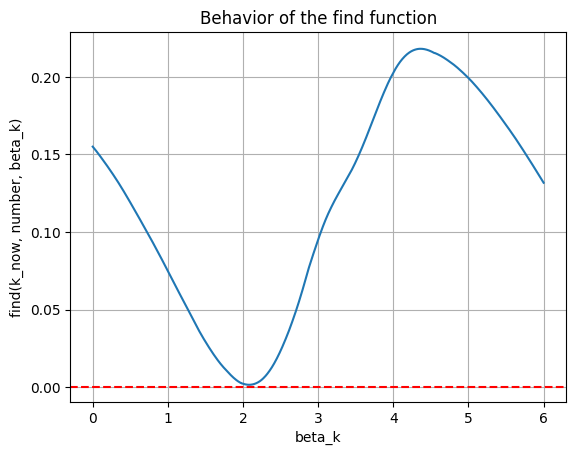

Top 8 beta_k with lowest errors:
beta_k: 2.0841, error: 0.0015
beta_k: 2.0781, error: 0.0015
beta_k: 2.0901, error: 0.0015
beta_k: 2.0721, error: 0.0015
beta_k: 2.0961, error: 0.0015
beta_k: 2.0661, error: 0.0015
beta_k: 2.1021, error: 0.0016
beta_k: 2.0601, error: 0.0016


In [294]:
# Example usage
# default = 0.03
number1 =  1200 - side +1200 * 8 + 400 # side = 395
bound = 3 #  +1 换bound

k_now = int(number1 / 1200)
visualize_find(lower=bound - 3,upper=bound + 3,k_now=k_now, number=number1)


In [295]:
# beta_k = 5.11
beta_k = 2.0841
print("error=",find(beta_k=beta_k,k_now=k_now,number=number1))
print("p_front=",get_result(beta_k=beta_k,k_now=k_now,number=number1))

error= 0.0015125861722031786
p_9= 1.0055786694056525
p_8= 1.0315219268545839
p_7= 1.0529927628084823
p_6= 1.0717695665830265
p_5= 1.089353004259729
p_4= 1.1047035193765813
p_front= 1.1140895198568206


In [140]:
def get_visual_result(beta_k,k_now,number):
    beta_list = []
    alpha_list = []
    c2 = linear(slide)

    t = number * dt

    if number % 1200 <= 1200-side: # 这个时候不在装水
        flag = True
        p_k = 1

        if k_now>0:
            alpha_k = reversed(linear(beta_k) - c2 - default)
        else:
            alpha_k = reversed(linear(beta_k) - c2)

        if number % 1200 == 1200-side and (not k_now in dictor):
            dictor[k_now] = linear(alpha_k)
            

        if  alpha_k < 0.01:  # 溢出
            print("GAME OVER")
            time.sleep(1)

        for k in range(k_now,-1,-1):

            if k == 0 and k_now > 0:
                c1 = c2 - default
            else:
                c1 = c2

            if flag:
                p_k = p_k - s * ((R-rr*alpha_k)*math.cos(alpha_k-w*t - gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
            else:
                break
                # return p_k

            # record
            alpha_list.append(alpha_k)
            beta_list.append(beta_k)

            if k == 0:
                break
            
            cons1 = dictor[k-1]/p_k+linear(beta_k)
            alpha_k = reversed(cons1) #actually k-1
            if alpha_k > threshold:
                flag = False
                continue

            beta_k = reversed(cons1 + c1) #actually k-1
            if beta_k > threshold:
                flag = False
                p_k += ((linear(threshold) - linear(alpha_k)) * factor  - (R - rr * alpha_k) * math.cos(alpha_k - w * t - gamma) + (R-rr*threshold)*math.cos(threshold-w*t-gamma)) * s
                
                # return p_k
                continue
    else:  # 这个时候在装水
        flag = True
        p_k = 1 - s * (R*math.cos(gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
        cons3 = dictor[k_now]/p_k+linear(beta_k)
        alpha_k = reversed(cons3) 
        # beta_k = reversed(cons3 + c1)
        if k_now > 0:
    
            beta_k = reversed(cons3 + c2 + default)
        else:
            beta_k = reversed(cons3 + c2)

        if  alpha_k < 0.01:
            print("GAME OVER")
            time.sleep(1)

        for k in range(k_now,-1,-1):

            if k == 0 and k_now > 0 :
                c1 = c2 - default
            else:
                c1 = c2
            
            if flag:
                p_k = p_k - s * ((R-rr*alpha_k)*math.cos(alpha_k-w*t - gamma)-(R-rr*beta_k)*math.cos(beta_k-w*t-gamma))
            else:
                continue
                # return p_k
            
            # record
            alpha_list.append(alpha_k)
            beta_list.append(beta_k)

            if k == 0:
                break
            cons1 = dictor[k-1]/p_k+linear(beta_k)
            alpha_k = reversed(cons1) #actually k-1
            if alpha_k > threshold:
                flag = False
                continue

            beta_k = reversed(cons1 + c1) #actually k-1
            if beta_k > threshold:
                
                flag = False
                p_k += ((linear(threshold) - linear(alpha_k)) * factor - (R - rr * alpha_k) * math.cos(alpha_k - w * t - gamma) + (R-rr*threshold)*math.cos(threshold-w*t-gamma)) * s
                
                continue
    return alpha_list,beta_list

def visual_curve(R, rr, number, alpha_list, beta_list):

    # 创建角度数组
    phi = np.linspace(0,  2 * np.pi * base_num, 1000) 
    
    # 计算半径
    r = R - rr * phi

    
    # 创建图形
    plt.figure(figsize=(10, 10))
    plt.polar(phi, r, 'k-',label='Spiral Curve')  # 绘制螺旋线

    # 使用颜色映射生成不同颜色
    cmap = plt.get_cmap('tab10')  # 选择一个颜色映射
    # 绘制alpha_list和beta_list中的角度线
    for i in range(len(alpha_list)):
        alpha = alpha_list[i]
        beta = beta_list[i]
        if beta > threshold:
            break
        if alpha > threshold:
            alpha = threshold
            
        # print(f'alpha_{i}', alpha)
        # print(f'beta_{i}', beta)
        
        # 为每个索引生成不同的颜色
        color_alpha = cmap(i % 10)  # 使用模运算确保索引在颜色映射范围内
        # 生成从 alpha 到 beta 的角度数组
        angles = np.linspace(alpha, beta, 100)
        
        radii = R - angles * rr
        plt.plot(angles, radii, color=color_alpha, linestyle='-')

        radii = R - (angles + np.pi * 2) * rr
        plt.plot(angles, radii, color=color_alpha, linestyle='-')
        
        theta = np.linspace(alpha,beta,400)
        for angles in theta:
            plt.polar([angles, angles], [R - (angles + np.pi * 2) * rr, R - angles * rr], 
                  color=color_alpha, linestyle='-')
            
        # # 绘制alpha线
        # plt.polar([alpha, alpha], [R - (alpha + np.pi * 2) * rr, R - alpha * rr], 
        #           color=color_alpha, linestyle='-')
        # # 绘制beta线
        # plt.polar([beta, beta], [R - (beta + np.pi * 2) * rr, R - beta * rr], 
        #           color=color_alpha, linestyle='-', label=f'index_{i}')
        
 
    # # 调整0度的位置到底部
    ax = plt.gca()
    ax.set_theta_offset(number / 1200 * np.pi * 2 - 0.55)  
    # 设置角度方向为顺时针
    ax.set_theta_direction(-1)
    
    # 添加图例和标题
    plt.legend(loc='upper right')
    plt.axis("off")
    # plt.title('Spiral Curve Visualization')
    
    
    # 显示图形
    plt.show()


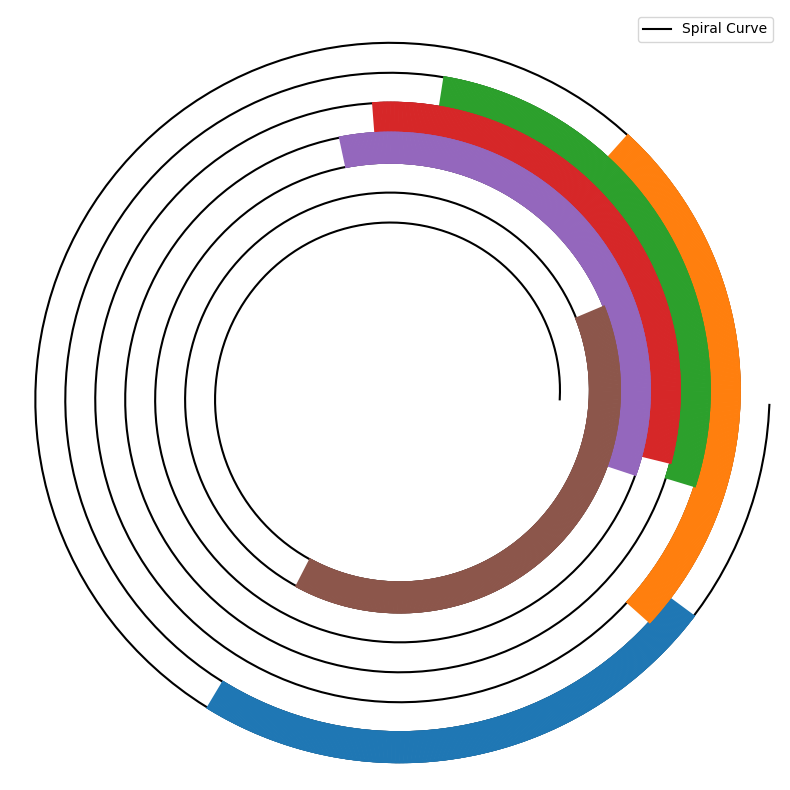

In [296]:
alpha_list, beta_list = get_visual_result(beta_k=beta_k,k_now=k_now,number=number1)
visual_curve(R=R,rr=rr,number=number1,alpha_list=alpha_list,beta_list=beta_list)